<a href="https://colab.research.google.com/github/sepidehrezvani/10-/blob/main/simulation_of_article_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio scikit-learn imbalanced-learn matplotlib pandas

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)

In [2]:
# اگر دیتاست واقعی داری، این بخش را جایگزین کن: df = pd.read_csv('...csv')
# داده مصنوعی سبک برای تست سریع (ویژگی‌ها و برچسب حمله/عادی)
n_samples = 20000
n_features = 30

X_normal = np.random.normal(0, 1, size=(n_samples//2, n_features))
X_attack = np.random.normal(1.5, 1.2, size=(n_samples//2, n_features))

X = np.vstack([X_normal, X_attack]).astype(np.float32)
y = np.array([0]*(n_samples//2) + [1]*(n_samples//2), dtype=np.int64)

df = pd.DataFrame(X, columns=[f"f{i}" for i in range(n_features)])
df["label"] = y

# Train/Val/Test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.2, stratify=train_df["label"], random_state=42)

features = [c for c in df.columns if c != "label"]
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[features].values)
X_val   = scaler.transform(val_df[features].values)
X_test  = scaler.transform(test_df[features].values)

y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = test_df["label"].values

In [3]:
# Logistic Regression
logreg = LogisticRegression(max_iter=200, n_jobs=1)
logreg.fit(X_train, y_train)
val_pred_lr = logreg.predict(X_val)
val_proba_lr = logreg.predict_proba(X_val)[:,1]

# Random Forest
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
val_pred_rf = rf.predict(X_val)
val_proba_rf = rf.predict_proba(X_val)[:,1]

def eval_metrics(y_true, y_pred, y_proba):
    return {
        "acc": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_proba)
    }

m_lr = eval_metrics(y_val, val_pred_lr, val_proba_lr)
m_rf = eval_metrics(y_val, val_pred_rf, val_proba_rf)

print("LogReg:", m_lr)
print("RandomForest:", m_rf)

LogReg: {'acc': 1.0, 'f1': 1.0, 'auc': np.float64(1.0)}
RandomForest: {'acc': 1.0, 'f1': 1.0, 'auc': np.float64(1.0)}


In [4]:
class MLPNet(nn.Module):
    def __init__(self, in_dim, h=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(h, h//2),
            nn.ReLU(),
            nn.Linear(h//2, 2)
        )
    def forward(self, x):
        return self.net(x)

def torch_loader(X, y, batch=256, shuffle=True):
    ds = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32),
                                        torch.tensor(y, dtype=torch.long))
    return torch.utils.data.DataLoader(ds, batch_size=batch, shuffle=shuffle)

train_loader = torch_loader(X_train, y_train)
val_loader   = torch_loader(X_val, y_val, shuffle=False)
test_loader  = torch_loader(X_test, y_test, shuffle=False)

model = MLPNet(in_dim=X_train.shape[1], h=128)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

def eval_dl(model, loader):
    model.eval()
    ys, preds, probas = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)[:,1]
            pred = torch.argmax(logits, dim=1)
            ys.append(yb.numpy()); preds.append(pred.numpy()); probas.append(probs.numpy())
    y_true = np.concatenate(ys); y_pred = np.concatenate(preds); y_proba = np.concatenate(probas)
    return {
        "acc": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_proba)
    }

epochs = 10
for ep in range(epochs):
    model.train()
    for xb, yb in train_loader:
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()
    m_val = eval_dl(model, val_loader)
    print(f"Epoch {ep+1:02d} | Val acc {m_val['acc']:.3f} | F1 {m_val['f1']:.3f} | AUC {m_val['auc']:.3f}")

m_test = eval_dl(model, test_loader)
print("MLP Test:", m_test)

Epoch 01 | Val acc 1.000 | F1 1.000 | AUC 1.000
Epoch 02 | Val acc 1.000 | F1 1.000 | AUC 1.000
Epoch 03 | Val acc 1.000 | F1 1.000 | AUC 1.000
Epoch 04 | Val acc 1.000 | F1 1.000 | AUC 1.000
Epoch 05 | Val acc 1.000 | F1 1.000 | AUC 1.000
Epoch 06 | Val acc 1.000 | F1 1.000 | AUC 1.000
Epoch 07 | Val acc 1.000 | F1 1.000 | AUC 1.000
Epoch 08 | Val acc 1.000 | F1 1.000 | AUC 1.000
Epoch 09 | Val acc 1.000 | F1 1.000 | AUC 1.000
Epoch 10 | Val acc 1.000 | F1 1.000 | AUC 1.000
MLP Test: {'acc': 0.9995, 'f1': 0.9994997498749375, 'auc': np.float64(1.0)}


In [5]:
class CNN1D(nn.Module):
    def __init__(self, in_len):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(8)
        )
        self.fc = nn.Sequential(
            nn.Linear(32*8, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        x = x.unsqueeze(1)              # [B,1,F]
        x = self.conv(x)                # [B,32,8]
        x = x.view(x.size(0), -1)       # [B,256]
        return self.fc(x)

cnn = CNN1D(in_len=X_train.shape[1])
opt_c = optim.Adam(cnn.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

epochs = 6
for ep in range(epochs):
    cnn.train()
    for xb, yb in train_loader:
        opt_c.zero_grad()
        loss = crit(cnn(xb), yb)
        loss.backward()
        opt_c.step()
    m_val = eval_dl(cnn, val_loader)
    print(f"[CNN] Epoch {ep+1:02d} | Val acc {m_val['acc']:.3f} | F1 {m_val['f1']:.3f} | AUC {m_val['auc']:.3f}")

m_test_cnn = eval_dl(cnn, test_loader)
print("CNN Test:", m_test_cnn)

[CNN] Epoch 01 | Val acc 1.000 | F1 1.000 | AUC 1.000
[CNN] Epoch 02 | Val acc 1.000 | F1 1.000 | AUC 1.000
[CNN] Epoch 03 | Val acc 1.000 | F1 1.000 | AUC 1.000
[CNN] Epoch 04 | Val acc 1.000 | F1 1.000 | AUC 1.000
[CNN] Epoch 05 | Val acc 1.000 | F1 1.000 | AUC 1.000
[CNN] Epoch 06 | Val acc 1.000 | F1 1.000 | AUC 1.000
CNN Test: {'acc': 0.9995, 'f1': 0.9994997498749375, 'auc': np.float64(1.0)}


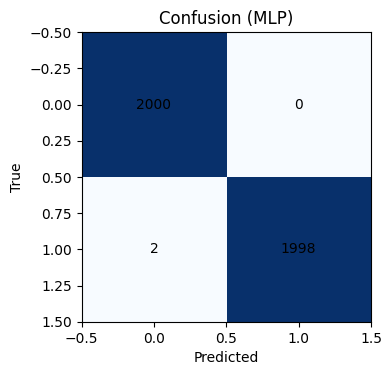

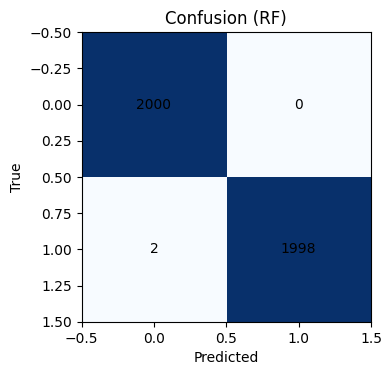

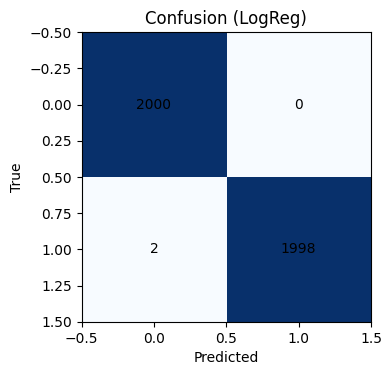

{'LogReg': {'acc': 1.0, 'f1': 1.0, 'auc': np.float64(1.0)}, 'RandomForest': {'acc': 1.0, 'f1': 1.0, 'auc': np.float64(1.0)}, 'MLP_Test': {'acc': 0.9995, 'f1': 0.9994997498749375}, 'RF_Test': {'acc': 0.9995, 'f1': 0.9994997498749375}}
Saved f1_compare.png


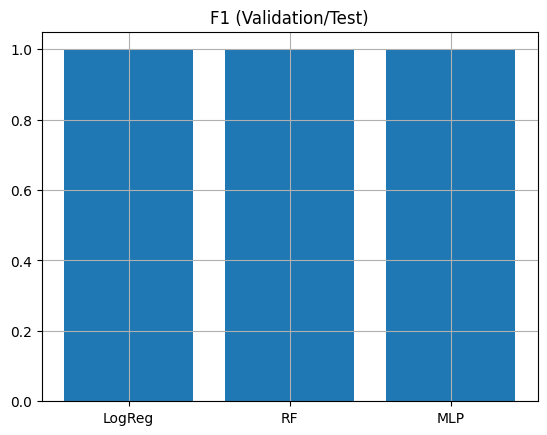

In [6]:
# مقایسه مدل‌ها روی Test
y_true = y_test
# MLP
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_test, dtype=torch.float32))
    y_pred_mlp = torch.argmax(logits, dim=1).numpy()
# RF
y_pred_rf_test = rf.predict(X_test)
# LogReg
y_pred_lr_test = logreg.predict(X_test)

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
    plt.tight_layout(); plt.show()
    return cm

cm_mlp = plot_confusion(y_true, y_pred_mlp, "Confusion (MLP)")
cm_rf  = plot_confusion(y_true, y_pred_rf_test, "Confusion (RF)")
cm_lr  = plot_confusion(y_true, logreg.predict(X_test), "Confusion (LogReg)")

# ذخیره نتایج خلاصه
summary = {
    "LogReg": m_lr,
    "RandomForest": m_rf,
    "MLP_Test": {
        "acc": accuracy_score(y_true, y_pred_mlp),
        "f1": f1_score(y_true, y_pred_mlp)
    },
    "RF_Test": {
        "acc": accuracy_score(y_true, y_pred_rf_test),
        "f1": f1_score(y_true, y_pred_rf_test)
    }
}
print(summary)

# ذخیره نمودار نمونه
plt.figure(); plt.bar(["LogReg","RF","MLP"],
                      [summary["LogReg"]["f1"], summary["RandomForest"]["f1"], summary["MLP_Test"]["f1"]])
plt.title("F1 (Validation/Test)"); plt.grid(True); plt.savefig("f1_compare.png")
print("Saved f1_compare.png")